# Bodyfat Data

The goal is to come up with a simple, accurate and robust way of determing body fat percentage of males based on readily available clinical measurement. The data set contains measurements from 252 men who had their body fat percentage accurately measured via underwater weighing and 14 other attributes.

Our ideas of our model are simple, robust and accurate. Simple means we need fewer variables. Robust means we have a higher tolerence to perturbation. And accurate means a lower MSE. Thus we decided to establish a linear regression model.

## Step1. Data Clean
### (1). Unreasonable bodyfat

In [2]:
suppressMessages(library(dplyr));suppressMessages(library(data.table));library(ggplot2)
body=fread("Bodyfat.csv")

$\#182$ and $\#172$ are obviously wrong data, since human beings couldn’t have body fat lower than 3% (blue line).
### (2). Wrong calculation of  bodyfat
We used the Siri's Equation to calculate the estimated bodyfat, and compared it with the real bodyfat. Some error may come from instrumental error, but some may not. The difference may come from the instrumental error, but $\#96$, $\#48$, $\#76$ may be wrong calculation.


### (3). Wrong calculation of adiposity

The adiposity (bmi) is calculated via the equation $$ Adiposity=\frac{703*Weight}{Height^2} $$
    
we compared the estimated adiposity with the real adiposity to find out the calculation error.

patient $\#42$ is obviously wrong data, and $\#163$ and $\#221$ may also be wrong data due to the wrong bmi calculation. For $\#42$, the estimated bodyfat is 165.6 and its real bodyfat is 29.9. For $\#163$, the estimated is 27.4 and the real is 24.4. For $\#221$,the estimated is 21.7 and real is 24.5.

### (4). Other weird indicator

There are many outliers for the circumference variables, we would like to check whether there existed wrong data.

For body[39,], outliers are in neck,chest,abdomen,hip,knee,thigh,ankle,wrist,biceps. This is an extra-obese guy, correct, but may has low contribution to the model. For body[41,], outliers are in chest,abdomen,hip,wrist. He is still an extra-obese guy, correct, but may has low contribution too. Also, we have some outliers in other data, which list as follow: abdomen of body[216,],thigh of body[169,],thigh and forearms of body[152,], ankle of body[86,], forearms of body[226,],forearms of body[45,], wrist of body[252,].

Also, there are some data who are outliers but reasonable, we have to retain them. For ankle of body[31,],this data is weird. This guy has a normal body, 172cm tall, 75kg weight, but his ankle has circumference 33.7cm. how could a guy has his thigh and knee thiner than average, but has an extra-big ankle? And forearms of body[175,]. This guy is also weird, he is 182cm tall, 103kg weight, but his forearms has circumference only 21cm.
From this step, we found 2 low contribution guy $\#39$ and $\#41$, and 2 weird data, $\#86$ has extra-big ankle and $\#175$ has extra-thin forearm.

### (5). Summary

In [3]:
strange=body[c(42,163,221,96,48,76,182,172,39,41,86,175),-c(1,4,8,9,10)]

In this step, we find some obvious wrong data, such as $\#182$ with 0 bodyfat and  $\#172$ with 1.9% bodyfat. $\#86$ with an extra-big-ankle and $\#175$ with an extra-small-forearm. Also, we find some strange data. $\#96$ have a wrong calculation of bodyfat (the data should fit a skeleton). $\#48$ and $\#76$ have wrong calculation of bodyfat with unknown reason. $\#42$ have wrong calculation of adiposity which is 29 inches tall. $\#163$ and $\#221$ have wrong calculation of adiposity with unknown reason. $\#39$ and $\#41$ are in extra-obese.

#### Why we didn't rewrite the data?
First, we didn’t know where does the wrong calculation come from, e.g., $\#48$ has wrong calculation of bodyfat, but we could trust neither the bodyfat nor the density. Same as the bmi calculation.Second, we want to obtain a higher accuracy for more people, so we abnegate sort of high leverage points. Third,the data size is large enough to abandon 12 out of 252 data. Thus, We deleted all those 12 data from the dataset. **

## Step 2: Statistical Modeling and Analysis

After the first step, we wanted to establish a statistical model and analyzed it. First, let’s see the scatter plot of some intuitively important variables to explore the trend using the cleaned data.

In [4]:
par(mfrow=c(1,3))
bodyfat=body[-c(39,41,42,48,76,86,96,163,172,175,182,221),]
b= ggplot(bodyfat, aes(ABDOMEN, BODYFAT,color=ABDOMEN)) + geom_point(shape=18,size=3)

In [5]:
model0 = lm(BODYFAT~ABDOMEN, data=bodyfat); #summary(model0);

In [6]:
sum((predict(model0,data=bodyfat)-bodyfat$BODYFAT)^2)/240

[1] 18.16735

After some tries on simple linear regression, we wanted to improve our model. Because the result of the simple 'Abdomen' model seemed good and reasonable, we wanted to improve our model to a multi-variate Regression Model. We decided to conduct AIC and BIC on our data.
First, we decided to conduct AIC.

In [7]:
model1 = lm(BODYFAT~.,data=subset(bodyfat,select = - DENSITY))
model1.aic = step(model1,k=2,trace=F)

In [8]:
sum((predict(model1.aic,data=bodyfat)-bodyfat$BODYFAT)^2)/240

[1] 14.83366

The model we gained from AIC is:

$$ \text{(Body Fat %)} = -31.73610 - 0.11525 * \text{Weight} + 0.91469 * \text{Abdomen} + 0.35836 * \text{Forearm} - 1.29107 * \text{Wrist}. $$

From the result, we can find that we still have 4 variables in the end. They are WEIGHT, ABDOMEN, FOREARM and WRIST. Then, we calculate the MSE, which is 14.83. The $R^2$ of the model is 0.737.

Then, we wanted to try BIC.

In [9]:
model1.bic = step(model1,k=log(240),trace=F);#summary(model1.bic)

In [10]:
sum((predict(model1.bic,data=bodyfat)-bodyfat$BODYFAT)^2)/240

[1] 15.04016

The model we gained from BIC is:

$$ \text{(Body Fat %)} = -26.80562 - 0.09373 * \text{Weight} + 0.89537 * \text{Abdomen} - 1.10949 * \text{Wrist}. $$

From the result of BIC, we had 3 variables at last. They are WEIGHT, ABDOMEN, and WRIST. The MSE of the BIC model is 15.04. The $R^2$ of the model is 0.733.

By comparison, when the $R^2$ and MSE are not very significantly different, we wanted to choose a model with simpler formation, which is the BIC model:

$$ \text{(Body Fat %)} = -0.1 * \text{Weight} + 0.9 * \text{Abdomen} - 1.1 * \text{Wrist}  - 26.8 . $$

## Step 3: Diagnostics

After model fitting, we typically made some diagnoses.

First, we checked the relationship BodyFat and the rest variants. From the pairs plot, we can see that BODYFAT has positive relationship with rest variants.

In [11]:
options(repr.plot.width=8, repr.plot.height=2.8);#pairs(BODYFAT~WEIGHT + ABDOMEN + WRIST, data=bodyfat) 

### (1). Outliers

Then we wanted to check the influential points and outliers by checking their residual plot, Pii plot and Cook's distance.  

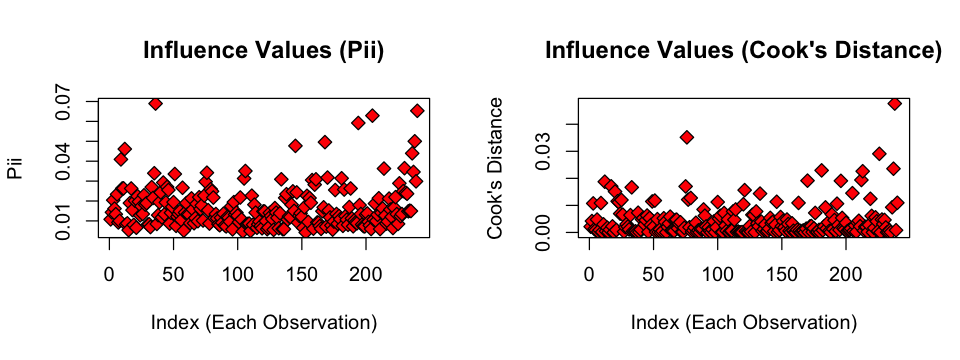

In [16]:
par(mfrow = c(1,2))
options(repr.plot.width=8, repr.plot.height=3);
plot(hat(model.matrix(model1.bic)),type="p",pch=23,bg="red",cex=1.2,
     xlab="Index (Each Observation)",ylab="Pii",main="Influence Values (Pii)")
plot(cooks.distance(model1.bic),type="p",pch=23,bg="red",cex=1.2,
     xlab="Index (Each Observation)",ylab="Cook's Distance",main="Influence Values (Cook's Distance)")

There is a point that has a higher cook’s distance than the rest, let’s find it out. However, we cannot find it suspicious. So, we cannot delete it.

### (2).	Homoscedasticity and independence

In [ ]:
 r = rstudent(model1.bic) 

homoscedasticity meets. And pattern is random, which means independence assumption is satisfied.

### (3). Normality

In [ ]:
options(repr.plot.width=6, repr.plot.height=2.8);
qqnorm(rstandard(model1.bic),pch=23,bg="red",cex=1)
abline(a=0,b=1,col="black",lwd=3)

Slightly heavy tail, but we still thought it meet normality.

### (4) multicolinearity

We tested the multicolinearity using VIF and F-test. The code is from packages "car", "ppcar", and "mctest", however, those packages couldn't been found in jupyter notebook. We posted the results here instead.

The Bic model passed the Determinant |X'X| and Sum of lambda Inverse, but failed in Farrar Chi-Square test, Red indicator, Theil's Method, Condition Number test. The VIF for three variables are both lower than 10, but the VIF for Weight is 5.33. These results indicated that there existed multicolinearity, but the problem is not so severe.

In [ ]:
#library(car);vif(model1.bic);library(mctest);x=bodyfat[,c(4,9,16)];omcdiag(x,bodyfat$BODYFAT)
#library(ppcor);pcor(x,"pearson");pcor(x,"pearson")

### (5). Test of robustness

We did multiple tests to test the robustness. First, using bootstrap subsample to test the robustness: a robust model should have its variable stay significant and its coefficients stay the same sign when the dataset have a little change. Second, when changing the independent variables or the dependent variable, the significance and sign of coefficients should stay the same.

In [ ]:
## variants permutation
#for (i in 1:ncol(bodyfat)) {            # test normality
#  p_value <- apply(bodyfat,2,shapiro.test)[[i]]$p.value
#  print(paste(names(bodyfat)[i],p_value,sep="    "))
#}  ### age adioposity chest violate the normality, delete them
#### Substitute WRIST Wwith NECK
submodel3 = lm(BODYFAT~WEIGHT+ABDOMEN+NECK,data=bodyfat);#summary(submodel3)

## Step 4: Conclusions 

In this part, we introduced the conclusions we got from our project.The final Model we want to use to predict body fat % is :
    
$$ \text{(Body Fat %)} = -0.1 * \text{Weight} + 0.9 * \text{Abdomen} - 1.1 * \text{Wrist}  - 26.8 . $$

**Possible rule of thumb**: "multiply your weight by - 0.1, your abdomen by 0.9, your wrist by -1.1 and minus 26.8"

**Example**: For instance, a graduate male student with weight 176 lbs, abdomen 88 cm, wrist 16 cm, would have a body fat around 17.74%. The 95% confident intervel of his body fat percentage is (15.86,19.62).

## Weakness of the model
First, abnegating too many observations may lose some important information. Second, existing multi-colinearity in pairs ”Weight-Abdomen”, but VIF indicates that multi-colinearity is not severe. Third, the accuracy still has room for improvement.

## Contributions of our members:
Canyang Liu:Did part of the data cleaning, especially found some weird data points. Finished the presentation slides.

Liyun Zeng: made the shiny app and wrote a part of the jupyter notebook report.

YEJIA LIAO: Model fitting, variants selection, diagnostics and organize github.